# EDA & 데이터 전처리

In [66]:
import pandas as pd
import librosa
import librosa.display
import csv
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np
import seaborn as sns
%matplotlib inline
import os
from PIL import Image

import warnings
warnings.filterwarnings('ignore')
plt.rc('font', family='Malgun Gothic')
sns.set(font="Malgun Gothic",#"NanumGothicCoding", 
        rc={"axes.unicode_minus":False}, # 마이너스 부호 깨짐 현상 해결
        style='darkgrid')

In [32]:
song_meta = pd.read_json('song_meta.json', typ = 'frame')
song_meta.head()

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
0,[GN0901],20140512,불후의 명곡 - 7080 추억의 얄개시대 팝송베스트,2255639,[2727],Feelings,[GN0900],[Various Artists],0
1,"[GN1601, GN1606]",20080421,"Bach : Partitas Nos. 2, 3 & 4",376431,[29966],"Bach : Partita No. 4 In D Major, BWV 828 - II....",[GN1600],[Murray Perahia],1
2,[GN0901],20180518,Hit,4698747,[3361],Solsbury Hill (Remastered 2002),[GN0900],[Peter Gabriel],2
3,"[GN1102, GN1101]",20151016,Feeling Right (Everything Is Nice) (Feat. Popc...,2644882,[838543],Feeling Right (Everything Is Nice) (Feat. Popc...,[GN1100],[Matoma],3
4,"[GN1802, GN1801]",20110824,그남자 그여자,2008470,[560160],그남자 그여자,[GN1800],[Jude Law],4


In [33]:
song_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707989 entries, 0 to 707988
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   song_gn_dtl_gnr_basket  707989 non-null  object
 1   issue_date              707989 non-null  int64 
 2   album_name              707985 non-null  object
 3   album_id                707989 non-null  int64 
 4   artist_id_basket        707989 non-null  object
 5   song_name               707989 non-null  object
 6   song_gn_gnr_basket      707989 non-null  object
 7   artist_name_basket      707989 non-null  object
 8   id                      707989 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 48.6+ MB


# 장르 코드

In [34]:
genre_gn_all = pd.read_json('genre_gn_all.json', typ = 'series')
genre_gn_all.head()

GN0100       발라드
GN0101    세부장르전체
GN0102       '80
GN0103       '90
GN0104       '00
dtype: object

In [35]:
genre_gn_all = pd.DataFrame(genre_gn_all, columns = ['gnr_name']).reset_index().rename(columns = {'index' : 'gnr_code'})
genre_gn_all.head()

,gnr_code,gnr_name
0,GN0100,발라드
1,GN0101,세부장르전체
2,GN0102,'80
3,GN0103,'90
4,GN0104,'00


# 곡 별 매핑 장르 수

In [36]:
# 곡 아이디(id)와 대분류 장르코드 리스트(song_gn_gnr_basket) 추출
song_gnr_map = song_meta.loc[:, ['id', 'song_gn_gnr_basket']]

# unnest song_gn_gnr_basket
song_gnr_map_unnest = np.dstack(
    (
        np.repeat(song_gnr_map.id.values, list(map(len, song_gnr_map.song_gn_gnr_basket))), 
        np.concatenate(song_gnr_map.song_gn_gnr_basket.values)
    )
)

# unnested 데이터프레임 생성 : song_gnr_map
song_gnr_map = pd.DataFrame(data = song_gnr_map_unnest[0], columns = song_gnr_map.columns)
song_gnr_map['id'] = song_gnr_map['id'].astype(str)
song_gnr_map.rename(columns = {'song_gn_gnr_basket' : 'gnr_code'}, inplace = True)

# unnest 객체 제거
del song_gnr_map_unnest

In [37]:
song_gnr_map.head()

,id,gnr_code
0,0,GN0900
1,1,GN1600
2,2,GN0900
3,3,GN1100
4,4,GN1800


# 특정 장르 음악만 추출

In [38]:
song_gnr_map=song_gnr_map.query("gnr_code in ['GN1600','GN0100','GN1000','GN1200','GN0300']")

In [39]:
song_gnr_map['gnr_code'].unique()

array(['GN1600', 'GN0300', 'GN0100', 'GN1200', 'GN1000'], dtype=object)

# 대분류 장르 코드가 1개인 음악만 추출

In [40]:
song_gnr_count = song_gnr_map.groupby('id').gnr_code.nunique().reset_index(name = 'mapping_gnr_cnt')
song_gnr_count=song_gnr_count.query('mapping_gnr_cnt in [1]')
song_gnr_count['mapping_gnr_cnt'].unique()

array([1], dtype=int64)

In [41]:
song_gnr_count.head()

,id,mapping_gnr_cnt
0,1,1
1,10,1
2,100003,1
3,100005,1
4,100009,1


In [42]:
song_gnr_count=song_gnr_count.drop('mapping_gnr_cnt',axis=1)

# 댄스,힙합,클래식,발라드의 장르 코드를 가지면서 1개만의 대분류 장르를 가진 음악 추출

In [43]:
song_gnr_count=pd.merge(song_gnr_count,song_gnr_map,how='inner',on='id')
song_gnr_count['id']=song_gnr_count['id'].astype('int64')
song_gnr_count.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240410 entries, 0 to 240409
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        240410 non-null  int64 
 1   gnr_code  240410 non-null  object
dtypes: int64(1), object(1)
memory usage: 5.5+ MB


In [44]:
song_gnr_count.head()

,id,gnr_code
0,1,GN1600
1,10,GN1200
2,100003,GN1000
3,100005,GN0100
4,100009,GN1600


# 메타 데이터와 병합

In [45]:
song_meta=pd.merge(song_meta,song_gnr_count,how='inner',on='id')
song_meta.shape

(240410, 10)

In [46]:
song_meta=song_meta.drop(['song_gn_gnr_basket','artist_id_basket','album_id','album_name'],axis=1)

In [47]:
song_meta.head()

,song_gn_dtl_gnr_basket,issue_date,song_name,artist_name_basket,id,gnr_code
0,"[GN1601, GN1606]",20080421,"Bach : Partita No. 4 In D Major, BWV 828 - II....",[Murray Perahia],1,GN1600
1,"[GN1601, GN1602, GN1614]",20170208,Sibelius : Valse Triste Op.44 (시벨리우스 : 슬픈 왈츠 작...,"[Herbert Blomstedt, San Francisco Symphony]",6,GN1600
2,"[GN1601, GN1602, GN1614]",20190315,Superman March (From &#34;Superman&#34; / Live...,"[Los Angeles Philharmonic Orchestra, Gustavo D...",7,GN1600
3,[GN0301],20070625,Lovers’ Leap (Feat. Qypthone),[애플스],8,GN0300
4,"[GN0105, GN0101]",20170320,"사랑, 그대라는 멜로디",[진호],9,GN0100


In [48]:
song_meta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240410 entries, 0 to 240409
Data columns (total 6 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   song_gn_dtl_gnr_basket  240410 non-null  object
 1   issue_date              240410 non-null  int64 
 2   song_name               240410 non-null  object
 3   artist_name_basket      240410 non-null  object
 4   id                      240410 non-null  int64 
 5   gnr_code                240410 non-null  object
dtypes: int64(2), object(4)
memory usage: 12.8+ MB


In [49]:
song_meta['gnr_code']=song_meta['gnr_code'].replace({'GN1200':'랩/힙합','GN0300':'랩/힙합',
                                                    'GN1000':'록/메탈','GN1600':'클래식',
                                                    'GN0100':'발라드'})
song_meta.head()

,song_gn_dtl_gnr_basket,issue_date,song_name,artist_name_basket,id,gnr_code
0,"[GN1601, GN1606]",20080421,"Bach : Partita No. 4 In D Major, BWV 828 - II....",[Murray Perahia],1,클래식
1,"[GN1601, GN1602, GN1614]",20170208,Sibelius : Valse Triste Op.44 (시벨리우스 : 슬픈 왈츠 작...,"[Herbert Blomstedt, San Francisco Symphony]",6,클래식
2,"[GN1601, GN1602, GN1614]",20190315,Superman March (From &#34;Superman&#34; / Live...,"[Los Angeles Philharmonic Orchestra, Gustavo D...",7,클래식
3,[GN0301],20070625,Lovers’ Leap (Feat. Qypthone),[애플스],8,랩/힙합
4,"[GN0105, GN0101]",20170320,"사랑, 그대라는 멜로디",[진호],9,발라드


In [50]:
song_meta['gnr_code'].unique()

array(['클래식', '랩/힙합', '발라드', '록/메탈'], dtype=object)

# 발매일이 정확히 명시되지 않는 음악 제거

In [51]:
song_meta=song_meta[song_meta['issue_date'].astype(str).str[-1:] != '0']
song_meta=song_meta[song_meta['issue_date'].astype(str).str[-2:] != '00']
song_meta=song_meta[song_meta['issue_date'].astype(str).str[-4:-2] != '00']
song_meta=song_meta[song_meta['issue_date'].astype(str).str[-4:] != '0000']

In [52]:
song_meta

,song_gn_dtl_gnr_basket,issue_date,song_name,artist_name_basket,id,gnr_code
0,"[GN1601, GN1606]",20080421,"Bach : Partita No. 4 In D Major, BWV 828 - II....",[Murray Perahia],1,클래식
1,"[GN1601, GN1602, GN1614]",20170208,Sibelius : Valse Triste Op.44 (시벨리우스 : 슬픈 왈츠 작...,"[Herbert Blomstedt, San Francisco Symphony]",6,클래식
2,"[GN1601, GN1602, GN1614]",20190315,Superman March (From &#34;Superman&#34; / Live...,"[Los Angeles Philharmonic Orchestra, Gustavo D...",7,클래식
3,[GN0301],20070625,Lovers’ Leap (Feat. Qypthone),[애플스],8,랩/힙합
5,[GN1201],20170407,Hi (Heyoo),[Miraa.],10,랩/힙합
...,...,...,...,...,...,...
240403,"[GN0105, GN0101]",20171012,너를 그리워해,[토요],707957,발라드
240404,"[GN0302, GN0301]",20060725,Love Evolution,[P&Q],707960,랩/힙합
240405,[GN0101],20110308,가을 우체국 앞에서,[어쿠스틱 콰이어],707967,발라드
240406,[GN1601],20130506,Mazurkas (1993 Digital Remaster): No. 33 in B ...,[Arthur Rubinstein],707968,클래식


In [53]:
song_meta = song_meta.drop('song_gn_dtl_gnr_basket',axis = 1)
song_meta.head()

,issue_date,song_name,artist_name_basket,id,gnr_code
0,20080421,"Bach : Partita No. 4 In D Major, BWV 828 - II....",[Murray Perahia],1,클래식
1,20170208,Sibelius : Valse Triste Op.44 (시벨리우스 : 슬픈 왈츠 작...,"[Herbert Blomstedt, San Francisco Symphony]",6,클래식
2,20190315,Superman March (From &#34;Superman&#34; / Live...,"[Los Angeles Philharmonic Orchestra, Gustavo D...",7,클래식
3,20070625,Lovers’ Leap (Feat. Qypthone),[애플스],8,랩/힙합
5,20170407,Hi (Heyoo),[Miraa.],10,랩/힙합


In [54]:
song_meta.to_csv('song_meta.csv')

In [55]:
song=pd.read_csv('song_meta.csv',index_col=0)

# 장르별 전체 데이터 수

In [57]:
song_classic=song[song['gnr_code']=='클래식']
song_rock=song[song['gnr_code']=='록/메탈']
song_rap=song[song['gnr_code']=='랩/힙합']
song_ballade=song[song['gnr_code']=='발라드']
print(song_classic['id'].nunique())
print(song_rock['id'].nunique())
print(song_rap['id'].nunique())
print(song_ballade['id'].nunique())

49880
54393
56483
48547


# 학습 데이터 개수

In [58]:
song1=song[(song['id']<107000) & (song['id']>=18000)]
song_classic=song1[song1['gnr_code']=='클래식']
song_rock=song1[song1['gnr_code']=='록/메탈']
song_rap=song1[song1['gnr_code']=='랩/힙합']
song_ballade=song1[song1['gnr_code']=='발라드']
print(song_classic['id'].nunique())
print(song_rock['id'].nunique())
print(song_rap['id'].nunique())
print(song_ballade['id'].nunique())

6356
6910
7047
6064


# 장르별 멜 스펙트로그램

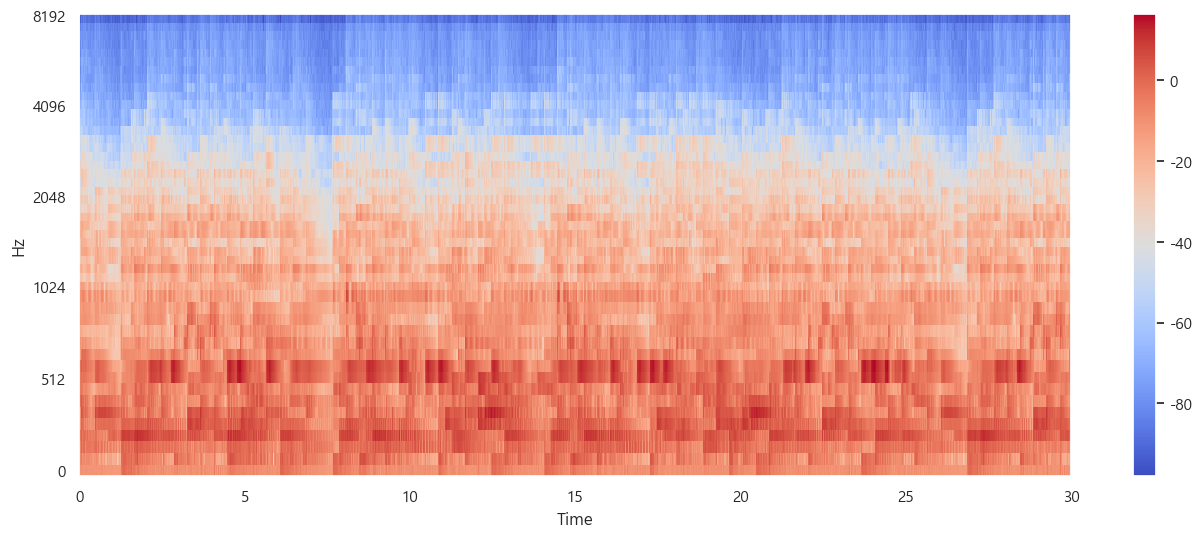

In [67]:
S=np.load('18/18016.npy') # 클래식
plt.figure(figsize=(16,6))
librosa.display.specshow(S, sr=16000,hop_length = 256, x_axis='time',y_axis='mel')
plt.colorbar()
plt.show()

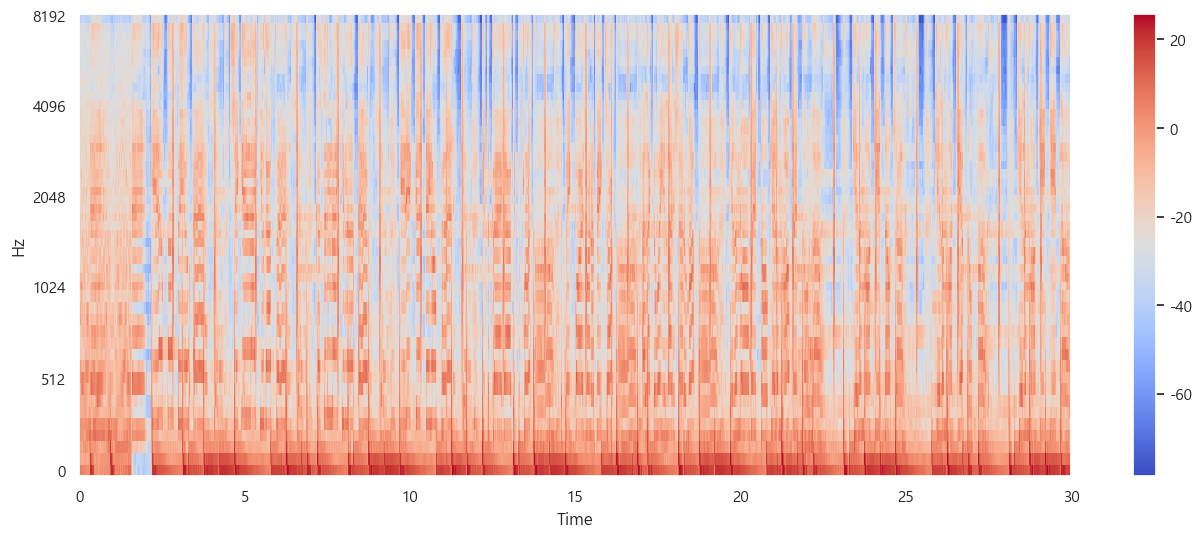

In [68]:
S=np.load('18/18059.npy') # 랩/힙합
plt.figure(figsize=(16,6))
librosa.display.specshow(S, sr=16000,hop_length = 256, x_axis='time',y_axis='mel')
plt.colorbar()
plt.show()

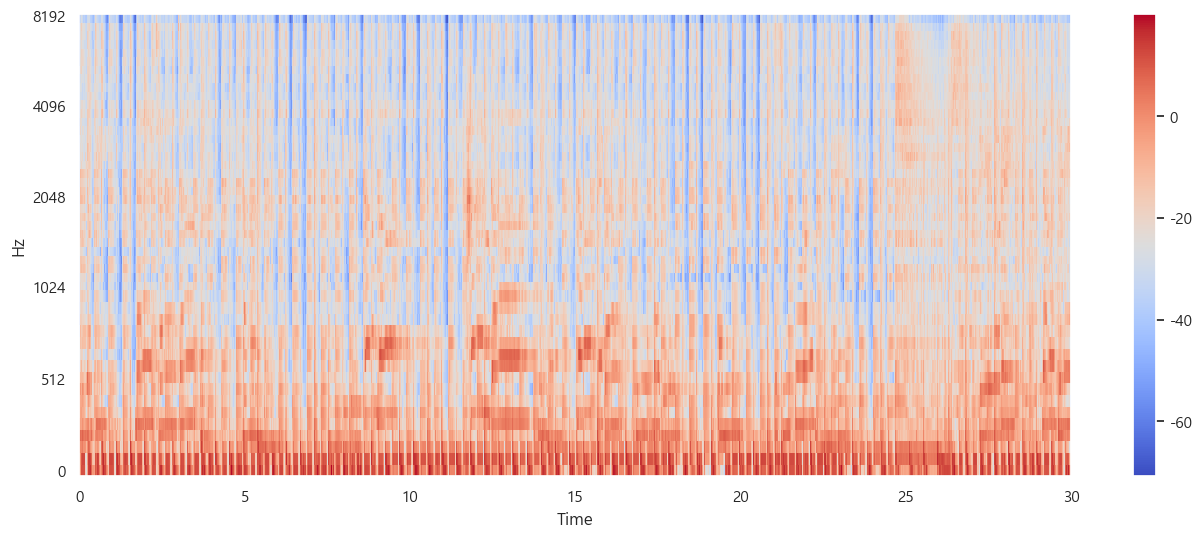

In [69]:
S=np.load('18/18027.npy') # 댄스
plt.figure(figsize=(16,6))
librosa.display.specshow(S, sr=16000,hop_length = 256, x_axis='time',y_axis='mel')
plt.colorbar()
plt.show()

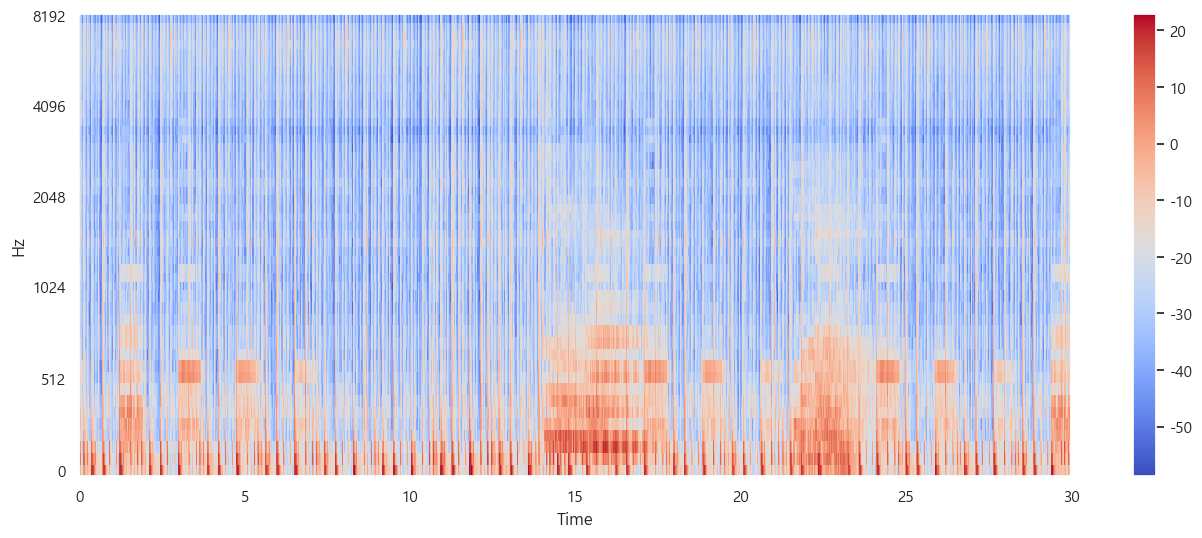

In [70]:
S=np.load('18/18001.npy') # 록/메탈
plt.figure(figsize=(16,6))
librosa.display.specshow(S, sr=16000,hop_length = 256, x_axis='time',y_axis='mel')
plt.colorbar()
plt.show()

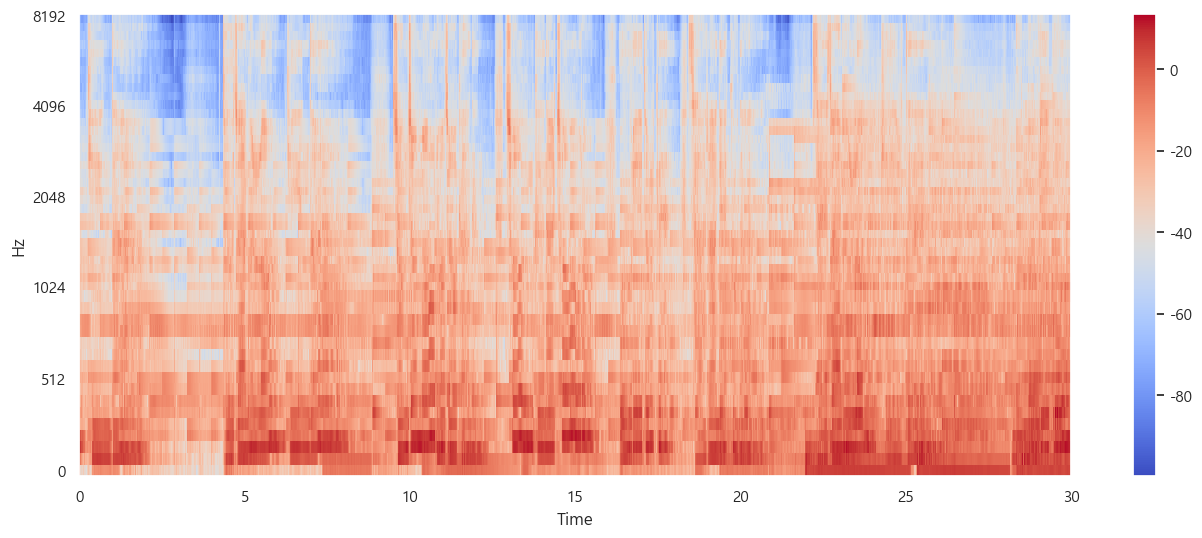

In [71]:
S=np.load('18/18052.npy') # 발라드
plt.figure(figsize=(16,6))
librosa.display.specshow(S, sr=16000,hop_length = 256, x_axis='time',y_axis='mel')
plt.colorbar()
plt.show()

# 멜 필터 1개마다 전체 프레임의 평균,분산 계산

In [ ]:
header='filename'
for i in range(1, 49):
    header += f' mel_mean{i}' 
    header += f' mel_var{i}'
header = header.split()

In [ ]:
file = open('data90_107.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
    
for filename in os.listdir('arena_mel_5/arena_mel'):
    for npy in os.listdir(f'arena_mel_5/arena_mel/{filename}'):
        songname=f'arena_mel_5/arena_mel/{filename}/{npy}'
        mel=np.load(songname)
        to_append=f'{npy}-.npy'
        for e in mel:
            to_append += f' {np.mean(e)}'
            to_append += f' {np.var(e)}'
        file = open('data90_107.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

In [ ]:
data18_35=pd.read_csv('data18_35.csv')
data36_53=pd.read_csv('data36_53.csv')
data54_71=pd.read_csv('data54_71.csv')
data72_89=pd.read_csv('data72_89.csv')
data90_107=pd.read_csv('data90_107.csv')

In [ ]:
b=data90_107.iloc[0:8000]
a=data90_107.iloc[8000:]
data90_107=pd.concat([a,b],axis=0)
data90_107=data90_107.reset_index(drop=True)

In [ ]:
data=pd.concat([data18_35,data36_53,data54_71,data72_89,data90_107])
data=data.drop('filename',axis=1).reset_index(drop=True)
data['id']=data.index+18000

In [ ]:
data.to_csv('data18_107.csv')

In [61]:
data=pd.read_csv('data18_107.csv',index_col=0)
data

,mel_mean1,mel_var1,mel_mean2,mel_var2,mel_mean3,mel_var3,mel_mean4,mel_var4,mel_mean5,mel_var5,...,mel_var44,mel_mean45,mel_var45,mel_mean46,mel_var46,mel_mean47,mel_var47,mel_mean48,mel_var48,id
0,-22.287693,29.279341,-21.811888,32.238495,-18.731527,33.485657,-18.496843,73.681168,-15.751297,146.486206,...,30.897482,-77.288597,27.107990,-78.270287,26.208948,-80.143806,23.749142,-87.623306,24.902794,18000
1,-5.962391,164.708191,-5.269400,156.650024,-7.788965,172.436356,-12.323392,190.411636,-13.889373,150.550476,...,55.141689,-25.791874,53.102703,-26.686378,62.576958,-28.202204,63.855526,-35.782257,62.882446,18001
2,-22.973152,47.615631,-13.559120,83.561584,-6.307430,42.149624,-3.847613,25.002604,-4.688787,46.637917,...,14.364228,-70.094963,7.657131,-70.255013,10.028666,-71.684593,8.313568,-79.389267,9.085979,18002
3,3.058554,66.858391,2.484022,36.898357,-1.923944,29.047258,-5.437521,32.840698,-6.466643,38.782406,...,58.153278,-37.175854,42.015072,-36.273556,40.836037,-39.160553,49.633446,-46.624649,45.889595,18003
4,-23.773043,81.034767,-16.908516,24.421095,-11.067135,24.326559,-7.142576,17.956818,-4.329798,22.388792,...,19.648766,-44.416775,18.033594,-45.731220,21.187000,-47.648071,21.135807,-57.295662,19.927118,18004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89995,1.099938,288.201385,-5.221201,241.607880,-5.554837,191.342148,-5.123359,177.236145,-7.980286,172.379425,...,139.022064,-26.441761,145.819565,-26.979921,151.271988,-28.698555,158.363983,-37.641186,162.495132,107995
89996,-18.538319,50.140472,-12.121573,49.163170,-8.482514,28.153015,-7.269070,42.225826,-6.304460,46.168949,...,101.252815,-76.358955,36.457832,-77.010910,37.423775,-78.785004,37.708229,-87.066742,23.545483,107996
89997,-18.488365,32.879192,-15.531822,41.499935,-14.125739,33.522869,-10.005608,52.109676,-9.781672,51.438057,...,87.872314,-61.729668,76.921928,-63.110531,79.334190,-69.102325,60.441204,-79.618851,49.713291,107997
89998,-25.087000,171.200882,-15.179061,166.860001,-12.156427,156.044128,-9.590431,111.998253,-3.435018,84.633240,...,311.143433,-40.283283,308.756866,-42.173187,313.196350,-45.752857,290.011536,-56.240688,269.739410,107998


In [62]:
song_data=pd.merge(song1,data,how='inner',on='id')
song_data

,issue_date,song_name,artist_name_basket,id,gnr_code,mel_mean1,mel_var1,mel_mean2,mel_var2,mel_mean3,...,mel_mean44,mel_var44,mel_mean45,mel_var45,mel_mean46,mel_var46,mel_mean47,mel_var47,mel_mean48,mel_var48
0,20150301,Scarborough Fair,['Claire Jones'],18000,클래식,-22.287693,29.279341,-21.811888,32.238495,-18.731527,...,-76.075195,30.897482,-77.288597,27.107990,-78.270287,26.208948,-80.143806,23.749142,-87.623306,24.902794
1,20110328,Feral,['Radiohead'],18001,록/메탈,-5.962391,164.708191,-5.269400,156.650024,-7.788965,...,-26.620602,55.141689,-25.791874,53.102703,-26.686378,62.576958,-28.202204,63.855526,-35.782257,62.882446
2,19920101,200 Bars,['Spiritualized'],18005,록/메탈,-15.672803,61.052334,-8.396144,44.536697,-10.794440,...,-61.476547,33.054832,-65.479027,53.141960,-68.703278,73.615791,-70.250175,73.298058,-78.002029,80.663559
3,19800723,Summer Romance,['The Rolling Stones'],18009,록/메탈,-0.651627,59.577152,0.886999,46.364414,-2.050753,...,-26.981031,42.079399,-26.912186,34.388931,-27.960892,34.131721,-30.832115,43.725037,-39.697147,51.316116
4,20150821,No Way Out,['Bullet For My Valentine'],18013,록/메탈,6.895680,27.149529,5.090122,21.877079,2.955578,...,-15.631028,13.141516,-18.265188,21.818455,-18.699680,24.931423,-20.146847,22.954941,-28.947878,25.681965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26372,20181201,SHINE,['이지혜'],106982,발라드,-16.126869,35.199886,-10.342628,41.845375,-9.456706,...,-60.052151,190.009476,-61.873226,176.886963,-61.286446,211.014526,-60.880230,246.487534,-68.433525,264.282776
26373,20180706,Something In the Water,['Tom Grennan'],106986,록/메탈,-5.258698,183.995148,-2.156284,67.000534,-1.081643,...,-35.441559,118.709404,-33.121429,139.402893,-32.091743,156.059540,-33.071774,167.853317,-41.317440,179.756516
26374,20171104,Beyond the Greed,['Dream Ocean'],106992,록/메탈,10.265122,33.506046,8.323609,18.134287,3.737123,...,-14.546819,11.224085,-17.007765,8.702065,-17.847815,8.759120,-19.820023,10.701080,-29.453915,13.130124
26375,20150119,These Eyes (Remastered),['The Guess Who'],106996,록/메탈,-4.552465,73.600410,2.505409,41.080330,-1.913496,...,-36.885544,79.399734,-37.999718,77.766556,-38.455574,81.719467,-39.259228,80.511101,-47.174149,80.680489


In [ ]:
# 음악 추천에 사용
song_data.to_csv('song_data_reco.csv')

In [63]:
song_data=song_data.drop(['issue_date','song_name',
                          'artist_name_basket','id'],axis=1)
song_data.head()

,gnr_code,mel_mean1,mel_var1,mel_mean2,mel_var2,mel_mean3,mel_var3,mel_mean4,mel_var4,mel_mean5,...,mel_mean44,mel_var44,mel_mean45,mel_var45,mel_mean46,mel_var46,mel_mean47,mel_var47,mel_mean48,mel_var48
0,클래식,-22.287693,29.279341,-21.811888,32.238495,-18.731527,33.485657,-18.496843,73.681168,-15.751297,...,-76.075195,30.897482,-77.288597,27.107990,-78.270287,26.208948,-80.143806,23.749142,-87.623306,24.902794
1,록/메탈,-5.962391,164.708191,-5.269400,156.650024,-7.788965,172.436356,-12.323392,190.411636,-13.889373,...,-26.620602,55.141689,-25.791874,53.102703,-26.686378,62.576958,-28.202204,63.855526,-35.782257,62.882446
2,록/메탈,-15.672803,61.052334,-8.396144,44.536697,-10.794440,26.851456,-15.538502,33.989197,-16.615633,...,-61.476547,33.054832,-65.479027,53.141960,-68.703278,73.615791,-70.250175,73.298058,-78.002029,80.663559
3,록/메탈,-0.651627,59.577152,0.886999,46.364414,-2.050753,32.145187,-5.367093,27.931442,-8.142079,...,-26.981031,42.079399,-26.912186,34.388931,-27.960892,34.131721,-30.832115,43.725037,-39.697147,51.316116
4,록/메탈,6.895680,27.149529,5.090122,21.877079,2.955578,23.950787,0.589654,30.271410,-2.522650,...,-15.631028,13.141516,-18.265188,21.818455,-18.699680,24.931423,-20.146847,22.954941,-28.947878,25.681965


In [ ]:
song_data.to_csv('song_data.csv')